<a href="https://colab.research.google.com/github/burrittresearch/burritt-research/blob/master/stock-market-forecasting-in-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Forecasting in Python
This notebook includes coding and notes for predicting prices of financial market assets including stocks, ETFs, and indices. A single class object was created to provide informational, cleaning, modeling, and visualization functions for processing financial asset data and predicting prices. Then all the available methods were run. Source data is downloaded using the [yfinance module](https://pypi.org/project/yfinance).

# Project Workflow
* Define the Problem
* Process Data
* Class Object AssetData Cleans, Models, and Visualizes Financial Data
* Run all Class Methods

# Define the Problem
Predict the future price of financial market assets including stocks, ETFs, and indices.

# Process Data

In [1]:
# Import libraries
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, 
  classification_report, 
  confusion_matrix, 
  f1_score, 
  mean_squared_error, precision_score,
  r2_score
) 
from sklearn.model_selection import train_test_split

# Install and import yfinance
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Set display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 3)



# Line break utility
str_lb = '\n \n'

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Class Object *AssetData* Cleans, Models, and Visualizes Financial Data

In [4]:
class AssetData:

  """
  Provides various informational, cleaning, modeling, and visualization functions for processing financial asset data
  and predicting prices. Source data is downloaded from yfinance and then processed.

  Parameters
  ----------
  str_co_ticker : str, required
    Any valid asset symbol.

  str_period : str, required, default 'max'
    Time duration for data.
    Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

  str_interval : str, required, default '1d'
    Time interval for data.
    Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

  update : bool, required, default False
    If True will download latest data and update csv file.
    If False will not download latest file data and will not update csv file.

  tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
     Tuple of valid intervals to run model.

  Methods
  ----------
  get_ticker
    Returns the asset ticker.
  
  get_period
    Returns the data time duration.
  
  get_interval
    Returns the data time interval.

  download_csv
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. Then looks to __init__ method for update. If file already exists and update argument is False, 
    then existing file is not updated. If File already exists and update argument is True, then existing file is updated. 
    If file doesn't exist, it is downloaded. Prints message indicating operations that were performed.

  get_raw_dataframes
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.

  explore_raw_dataframes
    Runs get_raw_dataframe and then prints basic dataframe information.

  get_clean_dataframes
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

  get_visual_data
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, 
    and regplots.
  
  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) 
    and dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_class_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

  run_class_model_list
    Runs run_class_model for a tuple of asset tickers.

  run_mlr_model
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

  run_mlr_model_list
    Runs run_mlr_model for a tuple of asset tickers.

  """

  def __init__(self, str_co_ticker, str_period='max', str_interval='1d', update=False, 
    tpl_model_intervals=('1d', '1wk', '1mo')):

    """
    Initializes the class

    Parameters
    ----------
    str_co_ticker : str, required
    Any valid asset symbol.

    str_period : str, required, default 'max'
      Time duration for data.
      Valid periods: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'

    str_interval : str, required, default '1d'
      Time interval for data.
      Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo'

    update : bool, required, default False
      If True will download latest data and update csv file.
      If False will not download latest file data and will not update csv file.

    tpl_model_intervals : tuple, required, default ('1d', '1wk', '1mo')
      Tuple of valid intervals to run model.

    NOTE: Data is downloaded to csv from yfinance given above paramters.
          Data is stored is default drive location indicated below.
    
    """      
    
    self.str_co_ticker = str_co_ticker
    self.str_period = str_period
    self.str_interval = str_interval
    self.str_drive_loc = '/content/drive/MyDrive/Colab Notebooks/input/'
    self.update = update
    self.tpl_model_intervals = list(tpl_model_intervals)
    self.lst_features_plots = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      'target_price', 
      'target_class'
    ]

    self.lst_features_model = ['open', 
      'high', 
      'low', 
      'close', 
      'volume', 
      # 'target_price', 
      # 'target_class'
    ]

    self.global_font = 10
    self.local_font = 12

  def get_ticker(self):
    
    """
    Gets the asset ticker.

    Returns
    ----------
    Ticker symbol.
    
    """

    return self.str_co_ticker

  def get_period(self):

    """
    Gets the data time period duration.

    Returns
    ----------
    Time period duration.
    
    """

    return self.str_period

  def get_interval(self):

    """
    Gets the data time interval.

    Returns
    ----------
    Time interval.
    
    """

    return self.str_interval

  def download_csv(self):

    """
    Downloads the data to a local csv file. First, checks to see if file exists at default google drive
    location. If file already exists and update argument is False, then existing file is not updated. If File 
    already exists and update argument is True, then existing file is updated. If file doesn't exist, it is downloaded.
    Prints message indicating operations that were performed.

    """

    update = self.update
    
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + 
      self.str_interval + '.csv')
    
    if Path(str_save_to_input).exists() is True and update is True:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)

    elif Path(str_save_to_input).exists() is True and update is False:
      print(f'FILE EXISTS: {str(Path(str_save_to_input))} UPDATE: NO{str_lb}')

    elif Path(str_save_to_input).exists() is False:
      print(f'FILE DOES NOT EXIST: {str(Path(str_save_to_input))} DOWNLOADED: YES{str_lb}')
      yf.download(self.str_co_ticker, period=self.str_period, interval=self.str_interval).to_csv(str_save_to_input)
    
    return
  
  def get_raw_dataframes(self):

    """
    Runs download_csv to check if file exists, needs updating, doesn't need updating, or needs downloading.
    Then creates dataframe from csv and performs basic cleaning processes.
    Returns the raw dataframe.
    
    Returns
    ----------
    Raw dataframe.

    """
 
    self.download_csv()
    str_save_to_input = (self.str_drive_loc + self.str_co_ticker  + '-price-data-' + self.str_period + '-' + 
      self.str_interval + '.csv')
    df = pd.read_csv(str_save_to_input, index_col=['Date'], parse_dates=['Date'])
    
    return df

  def explore_raw_dataframes(self):

    """
    Runs get_raw_dataframe and then prints basic dataframe information.

    """

    df = self.get_raw_dataframes()
    
    # Explore data
    df.info()

    print(f'df.head(): {str_lb}{df.head()}{str_lb}',    
      f'df.shape: {str_lb}{df.shape}{str_lb}',
      f'df.describe(): {str_lb}{df.describe()}{str_lb}',
      f'df.corr(method="pearson"): {str_lb}{df.corr(method="pearson")}{str_lb}'
    )

    return

  def get_clean_dataframes(self):

    """
    Runs get_raw_dataframe and then performs more advanced cleaning processes to prepare data from modeling.
    These include dropping unwanted features, renaming others, and creating price targets for classification
    and regression algorithms. 

    """

    df = self.get_raw_dataframes()

    # Drop and rename columns, rename index
    df.drop(['Adj Close'], axis=1, inplace=True)
    dict_rename = ({'Open':'open',
      'High':'high', 
      'Low':'low', 
      'Close':'close', 
      'Volume':'volume', 
    })
    df.rename(columns=dict_rename, inplace=True)
    df.index.rename('date', inplace=True)

    # Create target price and target class price from next period's close
    df['target_price'] = df['close'].shift(-1)
    df['target_class'] = np.where(df.target_price > df.close, 2, 1)

    # Slice the dataframe up one period to avoid target price null calculation 
    df = df.iloc[:-1]

    # Copy dataframe
    df = df.copy()
    
    return df
   
  def get_visual_data(self):

    """
    Runs get_clean_dataframes to prepare data. Then creates visualizations for optimizing feature selection including
    asset price line plot, feature correlation heatmap, pairplot, and feature and target pairplots, histograms, 
    and regplots.

    """

    # Set plot options
    plt.style.use('fivethirtyeight')
    sns.set_style("whitegrid")

    # Assign global font size
    plt.rcParams['font.size'] = self.global_font

    # Get clean dataframe for visualizations
    df = self.get_clean_dataframes()

    # Create line plot and correlation heatmap
    fig = plt.figure(figsize=(13.6, 4))
    fig.subplots_adjust(wspace=0.50, hspace=0.50) 

    # Line plot
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(df.close, label='Close')
    ax.set_title(f'Price', fontsize=self.local_font)
    ax.legend(loc='upper left')
    
    # Correlation heatmap
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f'Feature Correlation Heatmap', fontsize=self.local_font)
    sns.heatmap(df.corr(method = 'pearson'), cmap='Oranges', center=1, annot=True, fmt='.2f', linewidth=0.5)
    
    fig.suptitle(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}', 
      y=1.10, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Assign number of records to visualize pairplot
    int_rows = 10

    # Create pairplot of features list
    sns.set(font_scale=0.75)
    ax = sns.pairplot(df[-int_rows:], hue='target_price', vars=self.lst_features_plots, diag_kind='kde')
    ax.fig.set_size_inches(11.9, 7)
    ax.fig.suptitle(f'Feature and Target Pairplots (Records: {int_rows})', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)

    # Create histograms of features list
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      ax.hist(df[str_feature], bins=50, color='green', edgecolor='black')
      ax.set_title(str_feature, fontsize=self.local_font)
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Histograms', y=1.10, fontsize=self.local_font)
    
    plt.show()
    print(str_lb)

    # Create regplots of features and target
    fig = plt.figure(figsize=(13.2, 5))
    int_rows = math.ceil((len(self.lst_features_plots)/2))
      
    for int_index, str_feature in enumerate(self.lst_features_plots):
      
      ax = fig.add_subplot(int_rows, 2, int_index + 1)
      sns.regplot(x=df[str_feature], y=df['target_price'], color='blue', line_kws={'color': 'red', 'lw': 3})
      plt.subplots_adjust(hspace=0.75, wspace=0.25)
      fig.suptitle(f'Feature and Target Regplots', y=1.10, fontsize=self.local_font)
    
    plt.show()
    
    return

  def run_class_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs random forest classification algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

    Parameters
    ----------
    bool_get_reports : bool, default True
      If True will print various evaluation reports.
    
    bool_get_dfs : bool, default True
      If True, will print evaluation dataframes.
    ----------
    
    """
    
    # Create lists for scores
    lst_int = []
    lst_flt_accuracy_score = []
    lst_f1_score = []
    lst_flt_precision_score = []
    lst_flt_score = []

    # Create list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loop through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assign an interval to class attribute
      self.str_interval = interval

      # Check for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_class_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Print model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Get clean dataframe for model 
      df = self.get_clean_dataframes()

      # Create the training and test sets
      X = df[self.lst_features_model]
      y = df.target_class

      # Manually split sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Create the model using random forest classification
      rf_model_price_data = RandomForestClassifier()

      # Train the model
      rf_model_price_data.fit(X_train, y_train)

      # Predict asset values for test set
      y_hat = rf_model_price_data.predict(X_test)

      # Create new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_class'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluate the results
      flt_accuracy_score = accuracy_score(y_test, y_hat)
      flt_f1_score = f1_score(y_test, y_hat, average='macro')
      flt_precision_score = precision_score(y_test, y_hat)
      flt_score = rf_model_price_data.score(X_test, y_test)

      # Create lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_accuracy_score.append(flt_accuracy_score)
      lst_f1_score.append(flt_f1_score)
      lst_flt_precision_score.append(flt_precision_score)
      lst_flt_score.append(flt_score)

      # Create dictionary to store evaluation results
      dict_scores = {'lst_flt_accuracy_score':lst_flt_accuracy_score,
        'lst_f1_score':lst_f1_score,
        'lst_flt_precision_score':lst_flt_precision_score,
        'lst_flt_score':lst_flt_score
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Classification Report:{str_lb}{classification_report(y_test, y_hat)}{str_lb}')
        print(f"Crosstab Confusion Matrix:{str_lb}{pd.crosstab(df_pred.target_class, df_pred.target_pred, rownames=['Actual Classification'], colnames=['Predicted Classification'])}{str_lb}")
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        arr_conf_matrix = confusion_matrix(df_pred.target_class, df_pred.target_pred)
        sns.heatmap(arr_conf_matrix, cmap='Greens', center=1, annot=True, fmt='.1f', linewidth=0.5, xticklabels=['1', '2'], yticklabels=['1', '2'])
        ax.set_xlabel('Actual Classification')
        ax.set_ylabel('Predicted Classification')
        ax.set_title(f'Predicted vs Actual Asset Values Classification Model Confusion Matrix{str_lb}MODEL ASSET: {self.str_co_ticker}' 
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Print a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualize summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 4))
    ax = fig.add_subplot()
    df_score_comp_class.plot(kind='bar', ax=ax)
    ax.set_title(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', fontsize=self.local_font)
    ax.legend(loc='upper left')
    plt.show()
    print(str_lb)

    return 

  def run_class_model_list(self, tpl_assets):

    """
    Runs run_class_model for a tuple of asset tickers.

    """  

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
                  
    for asset in lst_assets:
       self.str_co_ticker = asset
       print(self.run_class_model())
    
    return

  def run_mlr_model(self, bool_get_reports=True, bool_get_dfs=True):

    """
    Runs get_clean_dataframes to prepare data. Then splits data and runs multiple linear regression algorithm for 
    intervals passed by tpl_model_intervals. By default, prints various evaluation reports (bool_get_reports) and 
    dataframes (bool_get_dfs) for each modeled interval. Then summarizes results of all model runs and prints 
    dataframe and visualization.

    """
    
    # Create lists for scores
    lst_int = []
    lst_flt_score = []
    lst_flt_r2_score = []
    lst_flt_mse = []

    # Create list for valid periods for running model
    lst_valid_periods = ['3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

    # Loop through intervals and run model
    for interval in self.tpl_model_intervals:
            
      # Assign an interval to class attribute
      self.str_interval = interval

      # Check for valid period
      if self.str_period not in lst_valid_periods:
        print(f'Please select a valid period and execute run_mlr_model() again: {str_lb}{lst_valid_periods}{str_lb}')
        return

      # Print model asset, period, and interval
      print(f'{str_lb}MODEL ASSET: {self.str_co_ticker} PERIOD: {self.str_period} INTERVAL: {self.str_interval}')

      # Get clean dataframe for model 
      df = self.get_clean_dataframes()

      # Create the training and test sets
      X = df[self.lst_features_model]
      y = df.target_price

      # Manually split sets by date to avoid leakage and then randomize
      flt_train_pct = 0.75
      flt_train_size = int(len(X)*flt_train_pct)

      X_train = X.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      X_test = X.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      y_train = y.iloc[:flt_train_size].sample(frac=1, random_state=0).copy()
      y_test = y.iloc[flt_train_size:].sample(frac=1, random_state=0).copy()

      # Create the model using multiple linear regression
      mlr_model_price_data = LinearRegression()

      # Train the model
      mlr_model_price_data.fit(X_train, y_train)

      # Predict asset values for test set
      y_hat = mlr_model_price_data.predict(X_test)

      # Create new dataframe comparing actual and predicted results
      df_pred = X_test.copy()
      df_pred['target_price'] = y
      df_pred['target_pred'] = y_hat
      df_pred = df_pred.sort_index()

      # Evaluate the results
      flt_score = mlr_model_price_data.score(X_test, y_test)
      flt_r2_score = r2_score(y_test, y_hat)
      flt_mse = mean_squared_error(y_test, y_hat)

      # Create lists for summary scores and dataframes
      lst_int.append(interval)
      lst_flt_score.append(flt_score)
      lst_flt_r2_score.append(flt_r2_score)
      lst_flt_mse.append(flt_mse)

      # Create dictionary to store evaluation results
      dict_scores = {'lst_flt_score':lst_flt_score,
        'lst_flt_r2_score':lst_flt_r2_score,
        'lst_flt_mse':lst_flt_mse,
      }

      # Boolean optional attribute for running reports and visualizations
      if bool_get_reports is True:
        print(f'Model Coefficents: {str_lb}{mlr_model_price_data.coef_}{str_lb}')
        print(f'Model Intercept: {str_lb}{mlr_model_price_data.intercept_}{str_lb}')

        # Plot the results
        plt.rcParams['font.size'] = self.global_font
        fig = plt.figure(figsize=(13.6, 4))
        ax = fig.add_subplot()
        x = df_pred.index
        y = df_pred.target_price
        y_hat = df_pred.target_pred
        ax.plot(x, y, color='g', label='target_price', linestyle='-', linewidth=2)
        ax.plot(x, y_hat, color='b', label='target_pred', linestyle=':', linewidth=5)
        ax.set_title(f'Predicted vs Actual Asset Values Using Multiple Regression{str_lb}MODEL ASSET: {self.str_co_ticker}'
          f'PERIOD: {self.str_period} INTERVAL: {self.str_interval}', fontsize=self.local_font)
        ax.legend(loc='upper left')
        plt.show()
        print(str_lb)

      # Boolean optional attribute for printing dataframes
      if bool_get_dfs is True:
        print(f'Feature, Target and Prediction Comparison: {str_lb}{df_pred.tail(10)}{str_lb}')

    # Print a dataframe of scores
    df_score_comp_class = pd.DataFrame.from_dict(dict_scores, orient='index', columns=lst_int)
    print(f'Predicted vs Actual Asset Values Score Summary: {str_lb}{df_score_comp_class}{str_lb}')

    # Visualize summary scores
    plt.rcParams['font.size'] = self.global_font
    fig = plt.figure(figsize=(13.6, 6))
    ax = fig.add_subplot(3, 1, 1)
    df_score_comp_class.loc['lst_flt_score':'lst_flt_r2_score'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    ax = fig.add_subplot(3, 1, 3)
    df_score_comp_class.loc['lst_flt_mse':'lst_flt_mse'].plot(kind='bar', ax=ax)
    ax.legend(loc='upper left')
    fig.suptitle(f'Predicted vs Actual Asset Values Score Summary{str_lb}MODEL ASSET: {self.str_co_ticker}', y=1.05, fontsize=self.local_font)
    plt.show()
    print(str_lb)
    
    return 

  def run_mlr_model_list(self, tpl_assets):

    """
    Runs run_mlr_model for a tuple of asset tickers.

    """

    lst_assets = list(tpl_assets)
    lst_assets.append(self.str_co_ticker)
                
    for asset in lst_assets:
      self.str_co_ticker = asset
      print(self.run_mlr_model())

    return



# Assign Asset Variables to Run All Methods

In [5]:
str_co_ticker_1 = '^GSPC'
str_co_ticker_2 = '^DJI'

# Method get_ticker

In [6]:
AssetData(str_co_ticker_1).get_ticker()

'^GSPC'

# Method get_period

In [7]:
AssetData(str_co_ticker_1).get_period()

'max'

# Method get_interval

In [8]:
AssetData(str_co_ticker_1).get_interval()

'1d'

# Method download_csv

In [9]:
AssetData(str_co_ticker_2).download_csv()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^DJI-price-data-max-1d.csv UPDATE: NO
 



# Method get_raw_dataframes

In [10]:
AssetData(str_co_ticker_1).get_raw_dataframes()


FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,17.66,0
1928-01-03,17.76,17.76,17.76,17.76,17.76,0
1928-01-04,17.72,17.72,17.72,17.72,17.72,0
1928-01-05,17.55,17.55,17.55,17.55,17.55,0
1928-01-06,17.66,17.66,17.66,17.66,17.66,0
...,...,...,...,...,...,...
2023-05-08,4136.98,4142.30,4123.81,4138.12,4138.12,3641640000
2023-05-09,4124.25,4130.35,4116.65,4119.17,4119.17,3810140000
2023-05-10,4143.74,4154.28,4098.92,4137.64,4137.64,4057160000


# Method explore_raw_dataframes

In [11]:
AssetData(str_co_ticker_1).explore_raw_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23956 entries, 1927-12-30 to 2023-05-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23956 non-null  float64
 1   High       23956 non-null  float64
 2   Low        23956 non-null  float64
 3   Close      23956 non-null  float64
 4   Adj Close  23956 non-null  float64
 5   Volume     23956 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.3 MB
df.head(): 
 
            Open   High   Low    Close  Adj Close  Volume
Date                                                     
1927-12-30  17.66  17.66  17.66  17.66  17.66      0     
1928-01-03  17.76  17.76  17.76  17.76  17.76      0     
1928-01-04  17.72  17.72  17.72  17.72  17.72      0     
1928-01-05  17.55  17.55  17.55  17.55  17.55      0     
1928-01-06  17.66  17.66  17.66  17.66  17.

# Method get_clean_dataframes

In [12]:
AssetData(str_co_ticker_1).get_clean_dataframes()

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 



,open,high,low,close,volume,target_price,target_class
date,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,17.76,2
1928-01-03,17.76,17.76,17.76,17.76,0,17.72,1
1928-01-04,17.72,17.72,17.72,17.72,0,17.55,1
1928-01-05,17.55,17.55,17.55,17.55,0,17.66,2
1928-01-06,17.66,17.66,17.66,17.66,0,17.50,1
...,...,...,...,...,...,...,...
2023-05-05,4084.73,4147.02,4084.73,4136.25,4186270000,4138.12,2
2023-05-08,4136.98,4142.30,4123.81,4138.12,3641640000,4119.17,1
2023-05-09,4124.25,4130.35,4116.65,4119.17,3810140000,4137.64,2


# Method get_visual_data

FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 



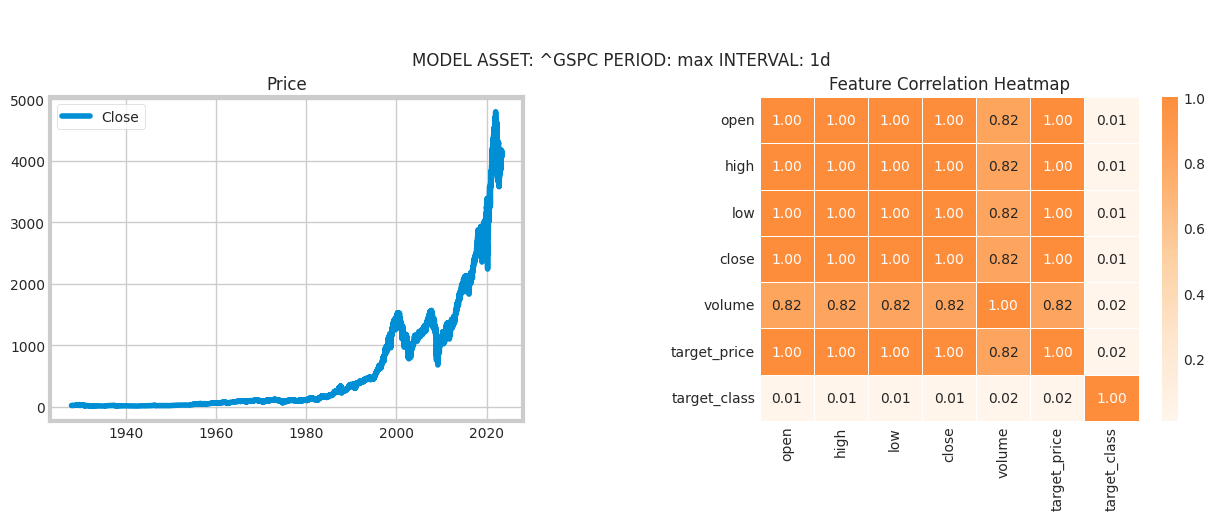

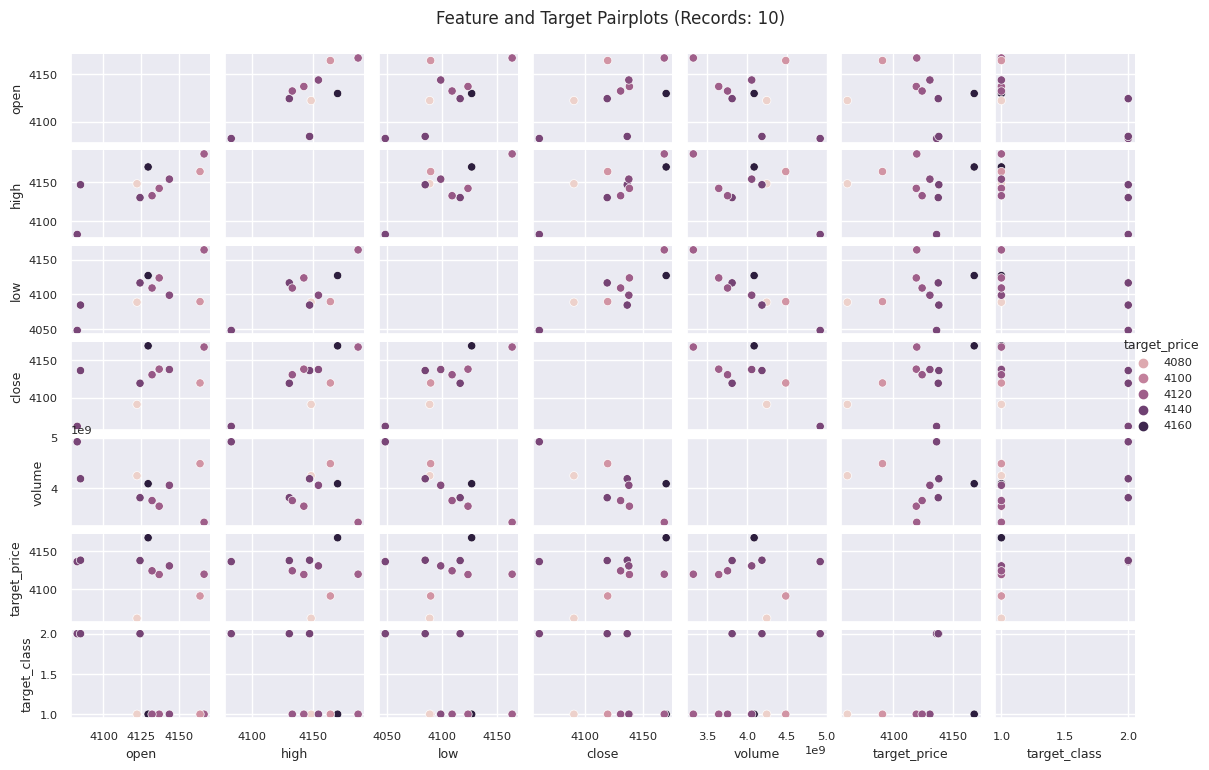

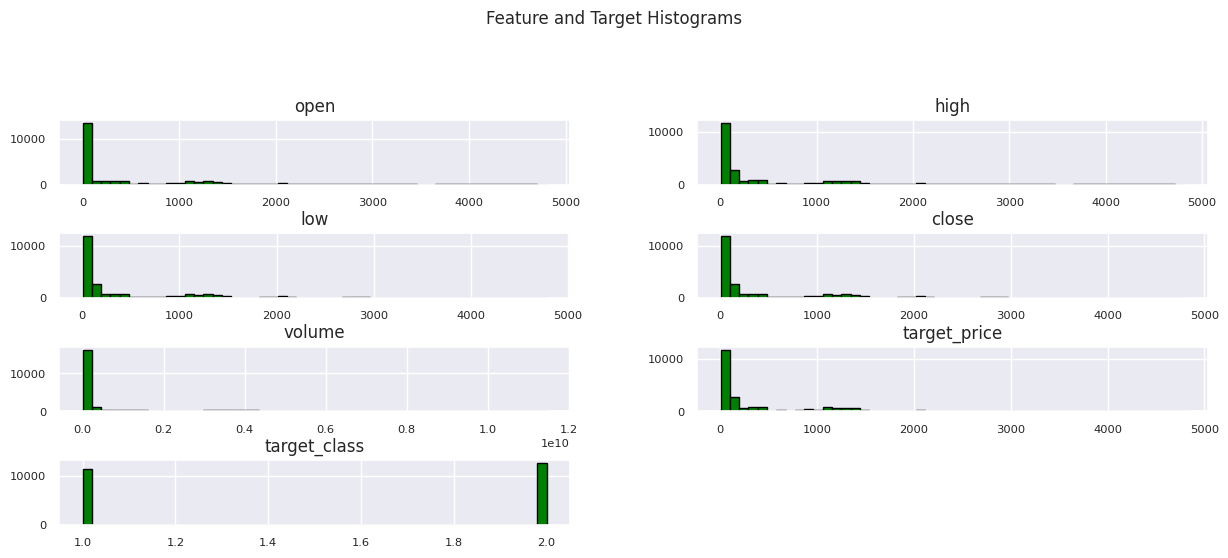

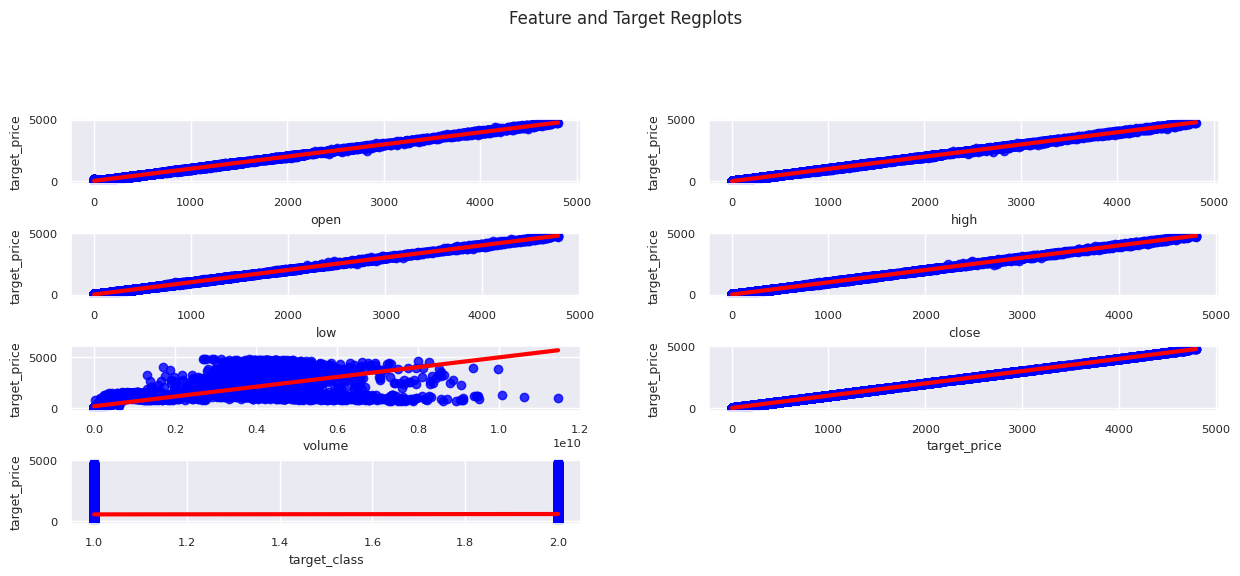

In [13]:
AssetData(str_co_ticker_1).get_visual_data()

# Method run_class_model


 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.47      0.25      0.32      2797
           2       0.53      0.75      0.62      3192

    accuracy                           0.52      5989
   macro avg       0.50      0.50      0.47      5989
weighted avg       0.50      0.52      0.48      5989

 

Crosstab Confusion Matrix:
 
Predicted Classification  1    2   
Actual Classification              
1                         693  2104
2                         785  2407
 



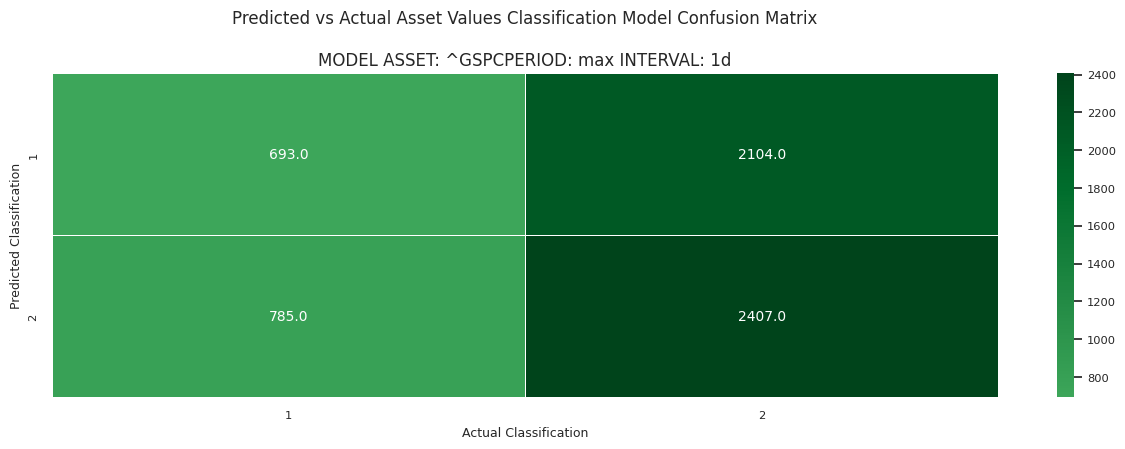


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  1             2          
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  1             2          
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  1             2          
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  1             2          
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  2             2          
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  2             2          
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  1             2          
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  2             2          
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  1             2          
2023

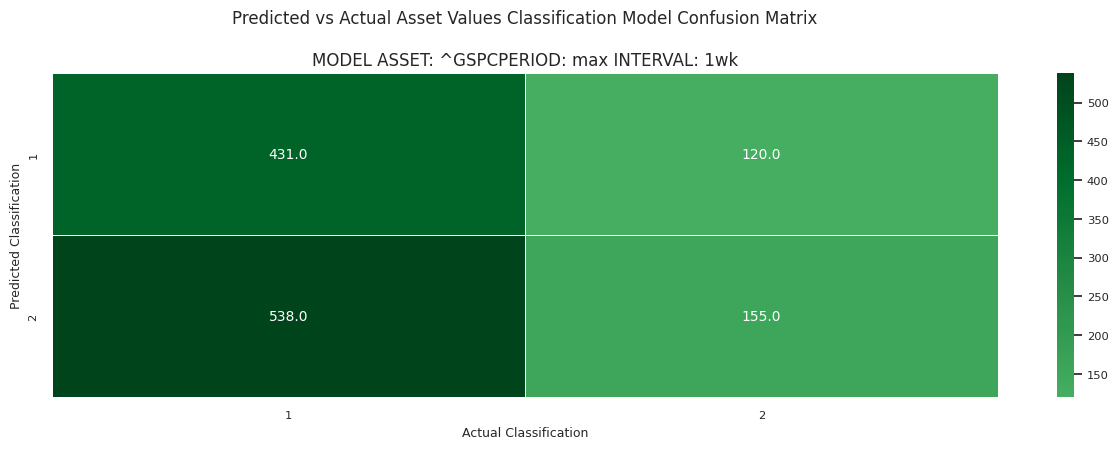


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  1             1          
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  2             1          
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  2             1          
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  2             1          
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  1             1          
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  2             1          
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  1             1          
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  2             1          
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  1             1    

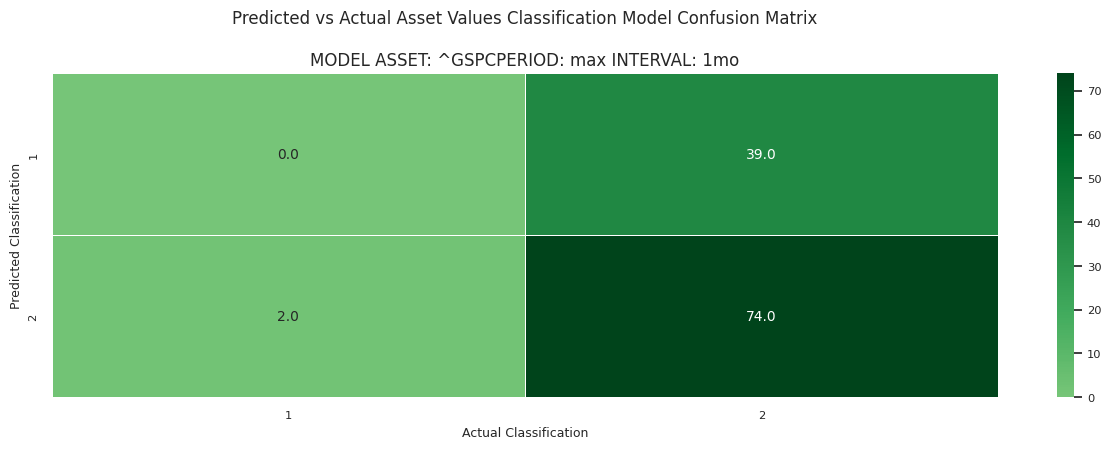


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_class  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  1             2          
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  1             2          
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  2             2          
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  2             2          
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  1             2          
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  2             2          
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  1             2          
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  2             2          
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  2       

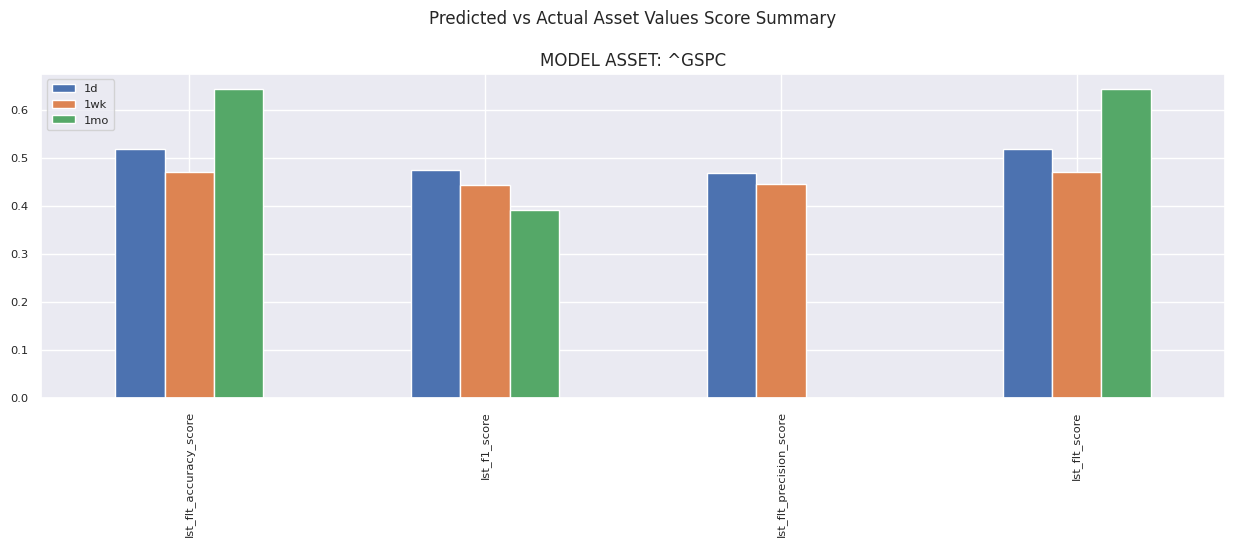

In [14]:
AssetData(str_co_ticker_1).run_class_model()

# Method run_class_model_list


 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.47      0.27      0.34      2797
           2       0.53      0.73      0.62      3192

    accuracy                           0.52      5989
   macro avg       0.50      0.50      0.48      5989
weighted avg       0.50      0.52      0.49      5989

 

Crosstab Confusion Matrix:
 
Predicted Classification  1    2   
Actual Classification              
1                         751  2046
2                         849  2343
 



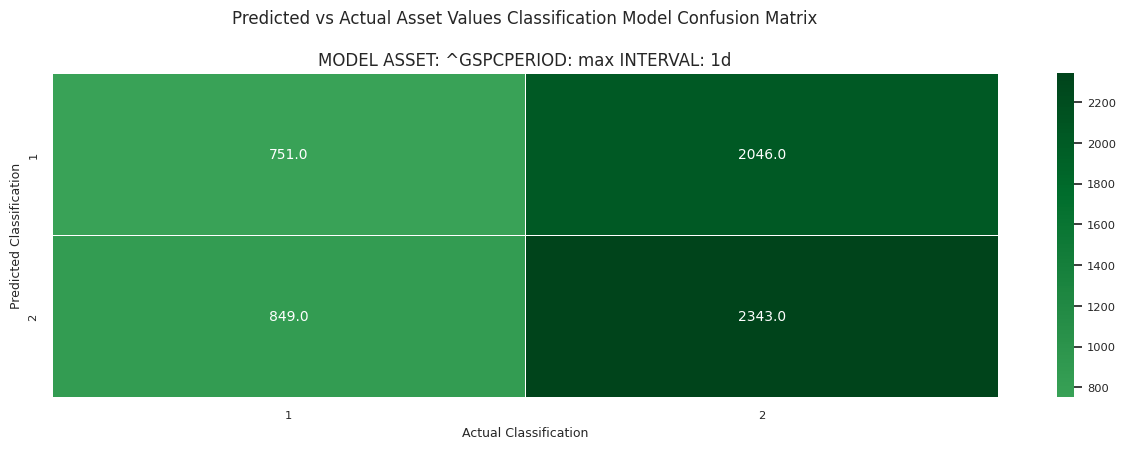


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  1             2          
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  1             2          
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  1             2          
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  1             2          
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  2             2          
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  2             2          
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  1             2          
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  2             2          
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  1             2          
2023

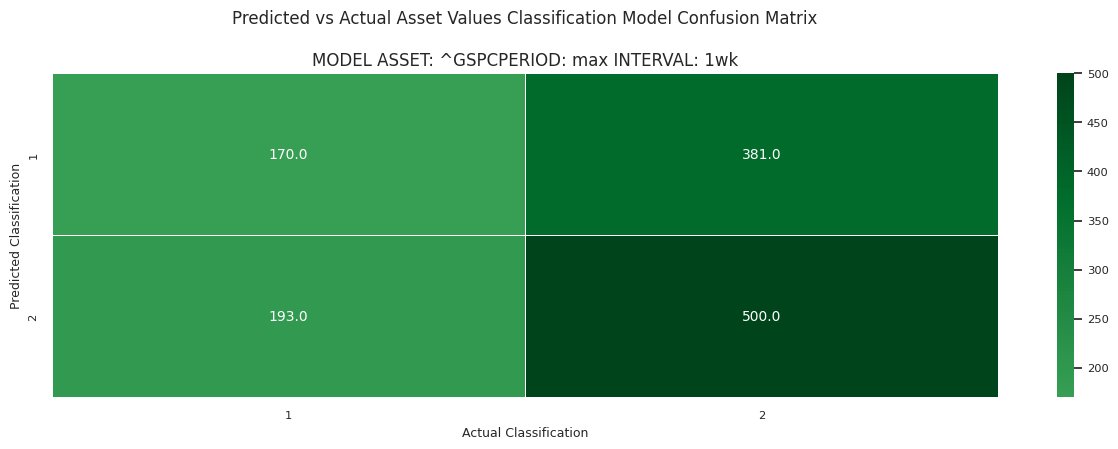


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  1             2          
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  2             2          
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  2             2          
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  2             2          
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  1             2          
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  2             2          
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  1             2          
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  2             2          
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  1             2    

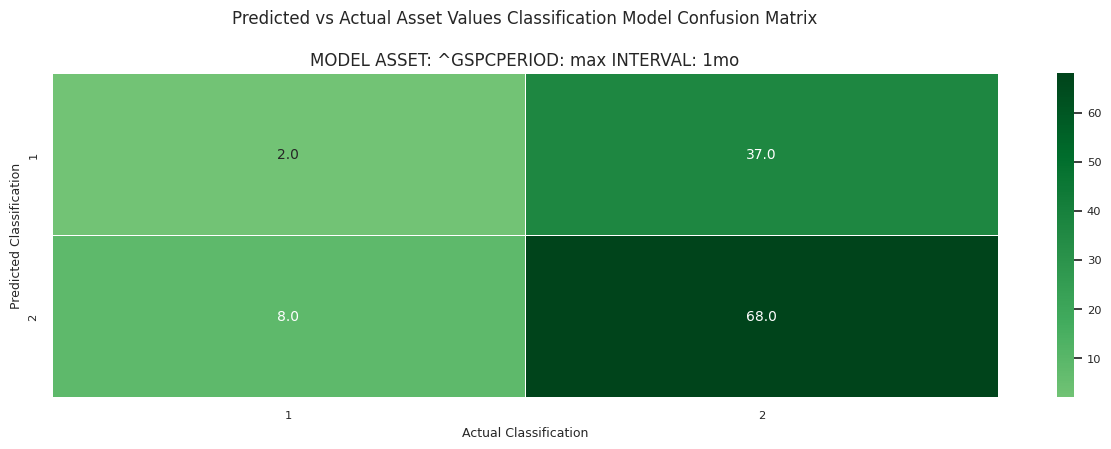


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_class  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  1             2          
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  1             2          
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  2             2          
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  2             2          
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  1             2          
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  2             2          
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  1             2          
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  2             2          
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  2       

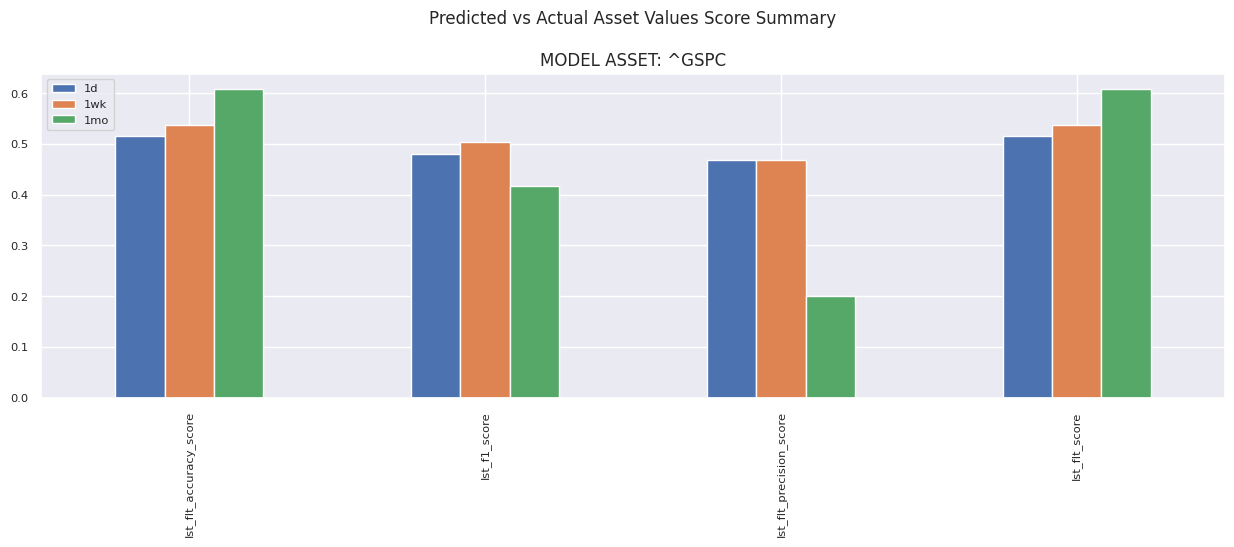


 

None

 
MODEL ASSET: ^DJI PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^DJI-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.49      0.26      0.34       911
           2       0.55      0.77      0.64      1064

    accuracy                           0.54      1975
   macro avg       0.52      0.52      0.49      1975
weighted avg       0.52      0.54      0.50      1975

 

Crosstab Confusion Matrix:
 
Predicted Classification  1    2  
Actual Classification             
1                         241  670
2                         248  816
 



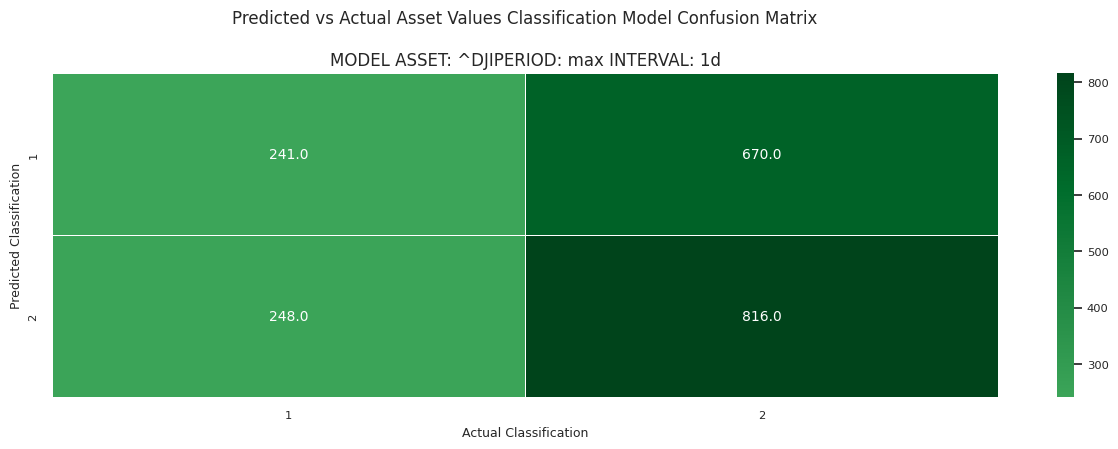


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume     target_class  target_pred
date                                                                                        
2023-04-28  33797.430  34104.559  33728.398  34098.160  354310000  1             2          
2023-05-01  34116.809  34257.828  34030.141  34051.699  244190000  1             2          
2023-05-02  34017.621  34017.750  33436.660  33684.531  274460000  1             2          
2023-05-03  33726.641  33811.840  33396.051  33414.238  286900000  1             2          
2023-05-04  33347.781  33354.859  32937.500  33127.738  305160000  2             2          
2023-05-05  33248.551  33748.430  33248.551  33674.379  316350000  1             2          
2023-05-08  33715.148  33747.488  33509.230  33618.691  225680000  1             2          
2023-05-09  33589.852  33656.398  33509.719  33561.809  232940000  1             2          
2023-05-10  33707.19

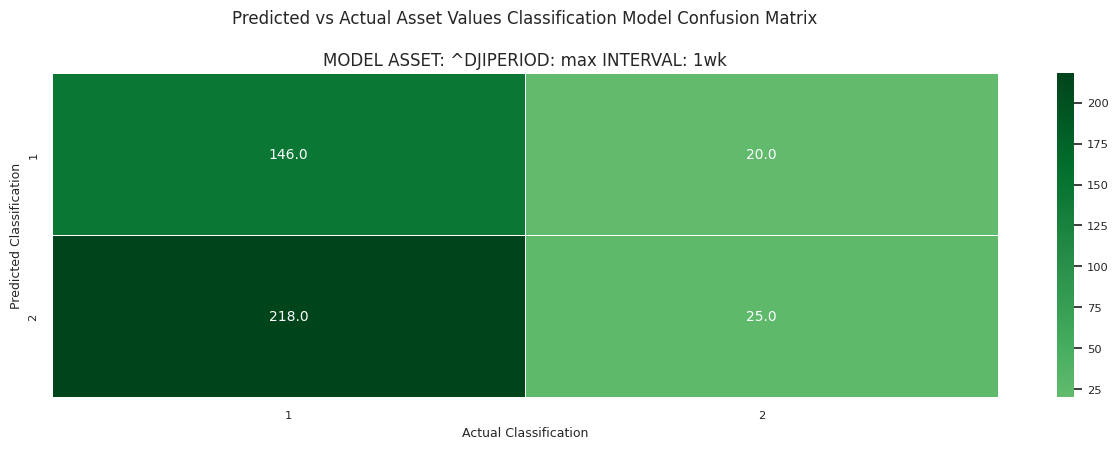


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume      target_class  target_pred
date                                                                                         
2023-03-01  32656.369  33572.219  32500.711  32856.461  1538900000  1             1          
2023-03-08  32872.078  32990.461  31624.869  32155.400  1777250000  2             1          
2023-03-15  31759.869  32593.680  31429.820  32560.600  2294350000  1             1          
2023-03-22  32570.189  32761.891  31805.180  32394.250  1518610000  2             1          
2023-03-29  32566.539  33634.719  32539.939  33402.379  1546480000  2             1          
2023-04-05  33394.602  33781.289  33325.371  33684.789  1019690000  2             1          
2023-04-12  33764.211  34082.941  33593.320  33976.629  1302350000  1             1          
2023-04-19  33889.828  33957.980  33525.391  33530.828  1400380000  2             1          
2023-04-26

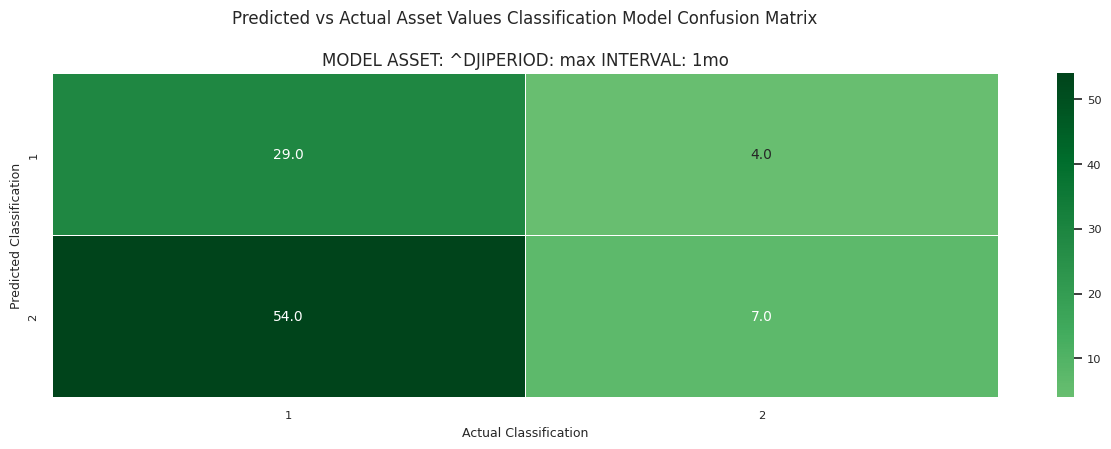


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume      target_class  target_pred
date                                                                                         
2022-07-01  30737.770  32910.180  30143.930  32845.129  6354530000  1             1          
2022-08-01  32755.711  34281.359  31509.590  31510.430  6960090000  1             1          
2022-09-01  31454.580  32504.039  28715.850  28725.510  7785160000  2             1          
2022-10-01  28855.250  32889.809  28660.939  32732.949  7758140000  2             1          
2022-11-01  32862.789  34589.770  31727.051  34589.770  7214910000  1             1          
2022-12-01  34533.590  34712.281  32573.430  33147.250  6980640000  2             1          
2023-01-01  33148.898  34342.320  32812.328  34086.039  6774530000  1             1          
2023-02-01  34039.602  34334.699  32636.430  32656.699  6105230000  2             1          
2023-03-01

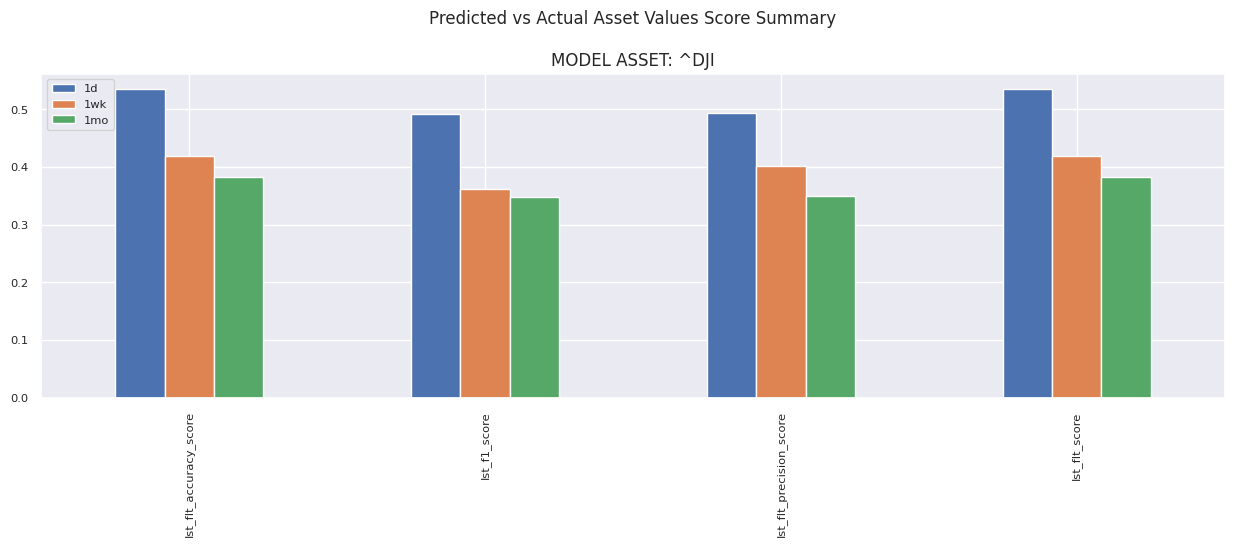


 

None

 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Classification Report:
 
              precision    recall  f1-score   support

           1       0.47      0.27      0.34      2797
           2       0.53      0.73      0.61      3192

    accuracy                           0.51      5989
   macro avg       0.50      0.50      0.48      5989
weighted avg       0.50      0.51      0.49      5989

 

Crosstab Confusion Matrix:
 
Predicted Classification  1    2   
Actual Classification              
1                         757  2040
2                         869  2323
 



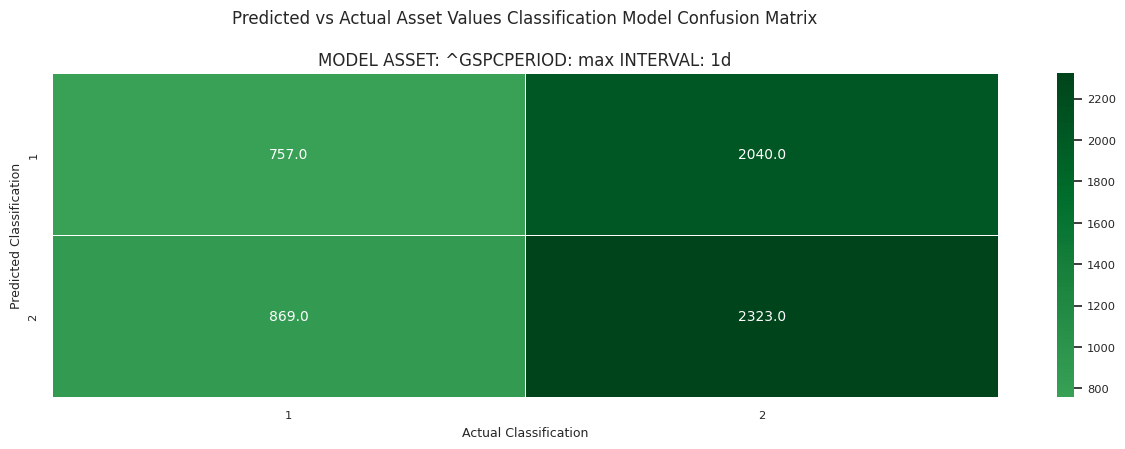


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_class  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  1             2          
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  1             2          
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  1             2          
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  1             2          
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  2             2          
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  2             2          
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  1             2          
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  2             2          
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  1             2          
2023

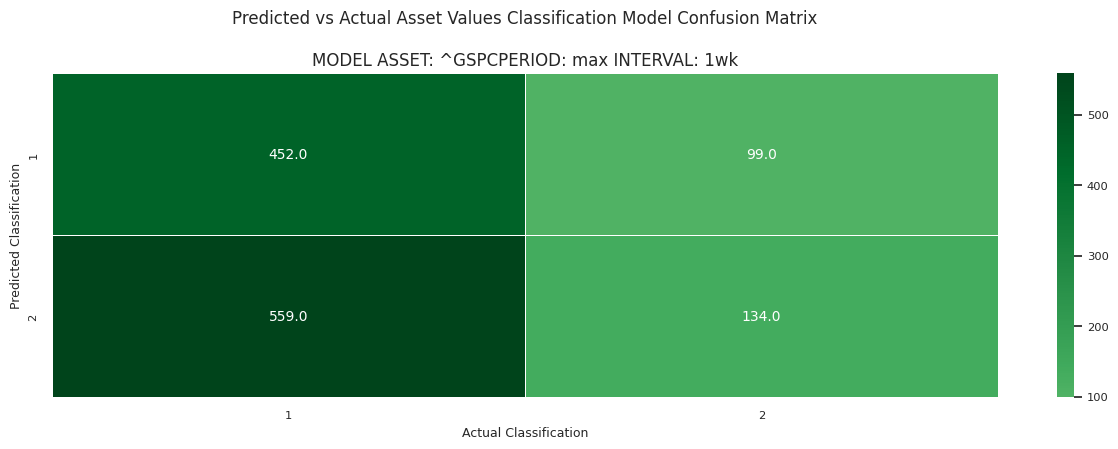


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_class  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  1             1          
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  2             1          
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  2             1          
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  2             1          
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  1             1          
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  2             1          
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  1             1          
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  2             1          
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  1             1    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

Classification Report:
 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        39
           2       0.66      1.00      0.80        76

    accuracy                           0.66       115
   macro avg       0.33      0.50      0.40       115
weighted avg       0.44      0.66      0.53       115

 

Crosstab Confusion Matrix:
 
Predicted Classification  2 
Actual Classification       
1                         39
2                         76
 



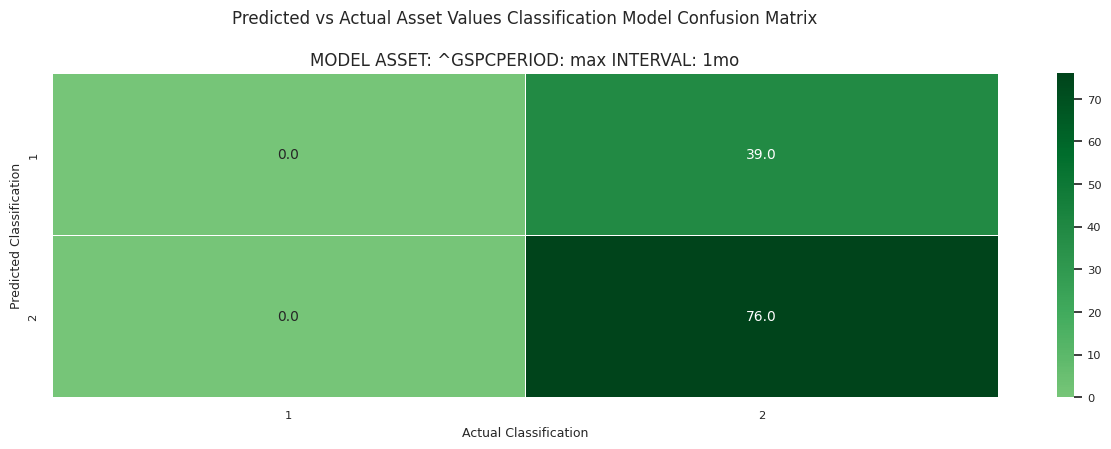


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_class  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  1             2          
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  1             2          
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  2             2          
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  2             2          
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  1             2          
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  2             2          
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  1             2          
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  2             2          
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  2       

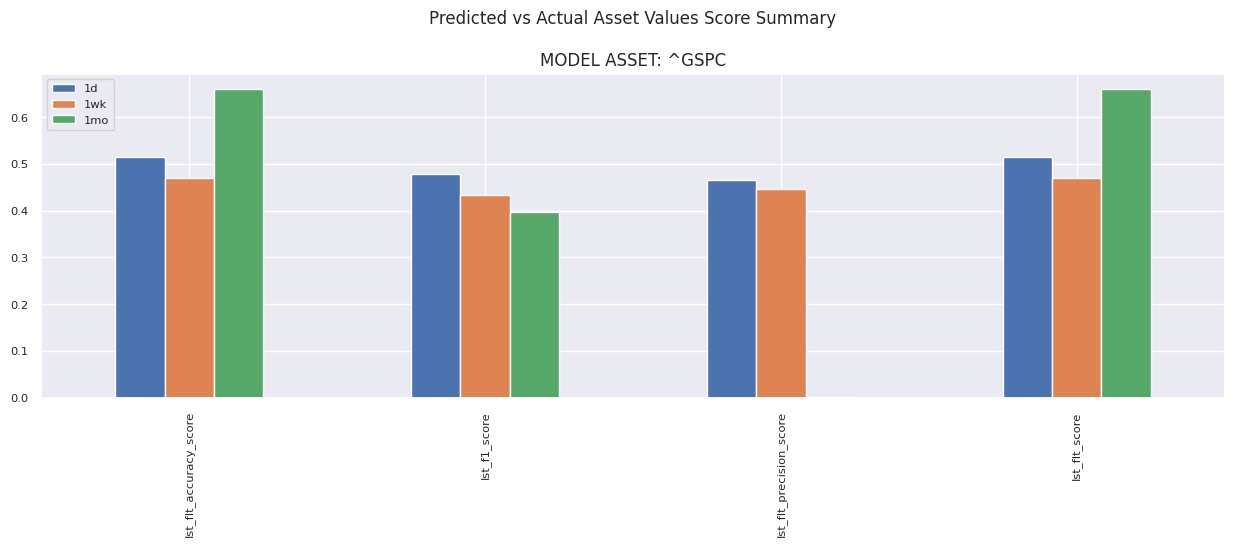


 

None


In [15]:
AssetData(str_co_ticker_1).run_class_model_list([str_co_ticker_1, str_co_ticker_2])

# Method run_mlr_model


 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[ 1.38421888e-03  1.09736775e-01 -9.22012809e-02  9.80540094e-01
 -2.08889100e-10]
 

Model Intercept: 
 
0.029760617776872778
 



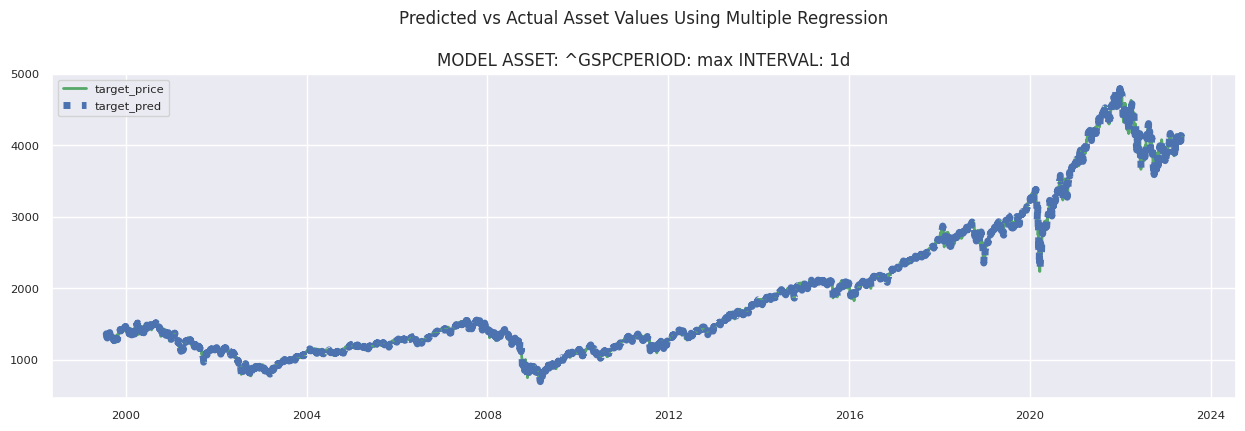


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  4167.87       4170.312   
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  4119.58       4167.389   
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  4090.75       4124.148   
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  4061.22       4094.216   
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  4136.25       4061.598   
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  4138.12       4139.032   
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  4119.17       4136.930   
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  4137.64       4117.645   
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  4130.62       4139.992   
2023

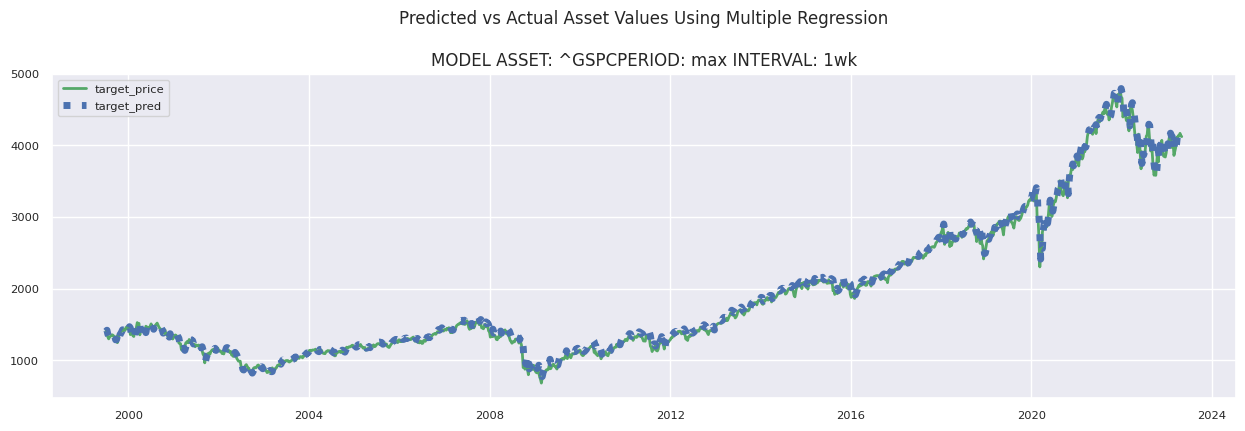


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  3861.59       4073.750   
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  3916.64       3919.954   
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  3970.99       3978.881   
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  4109.31       4020.189   
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  4105.02       4128.096   
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  4137.64       4136.890   
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  4133.52       4168.381   
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  4169.48       4174.054   
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  4136.25       4190.

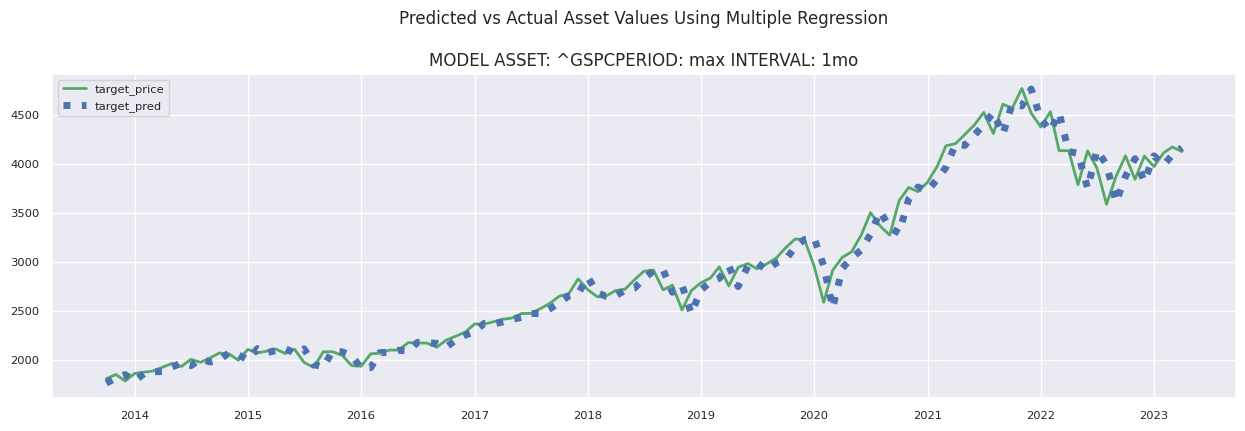


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_price  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  3955.00       4137.310   
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  3585.62       3989.300   
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  3871.98       3606.066   
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  4080.11       3868.906   
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  3839.50       4050.376   
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  4076.60       3818.013   
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  3970.15       4079.506   
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  4109.31       3985.187   
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  4169.48 

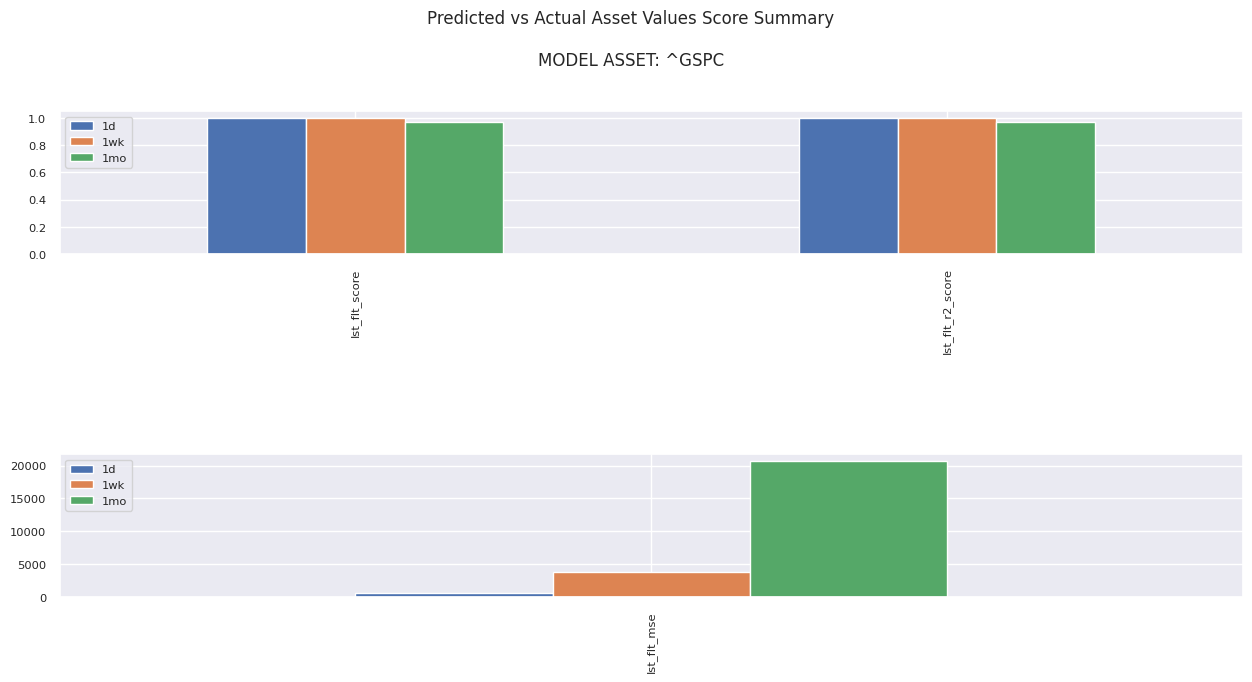

In [16]:
AssetData(str_co_ticker_1).run_mlr_model()

# Method run_mlr_model_list


 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[ 1.38421888e-03  1.09736775e-01 -9.22012809e-02  9.80540094e-01
 -2.08889100e-10]
 

Model Intercept: 
 
0.029760617776872778
 



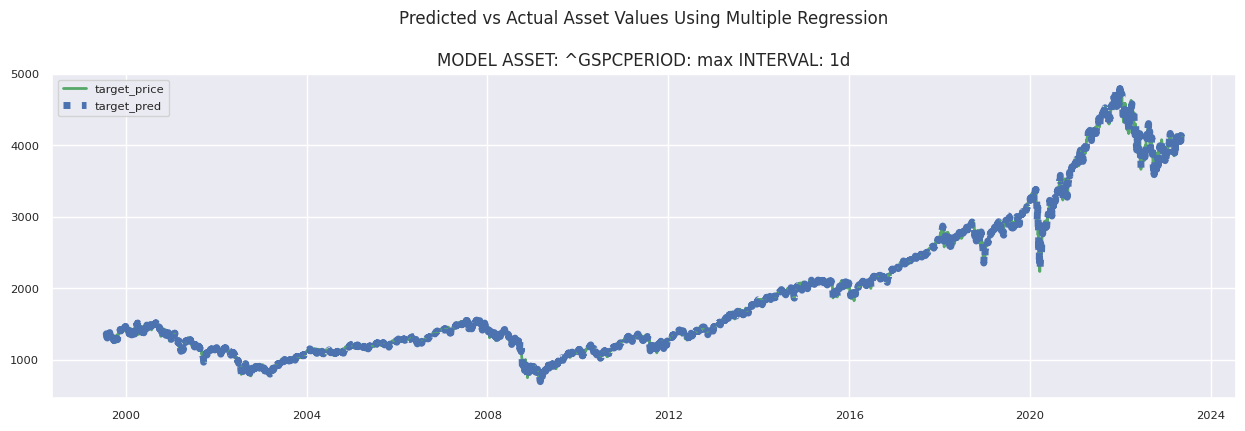


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  4167.87       4170.312   
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  4119.58       4167.389   
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  4090.75       4124.148   
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  4061.22       4094.216   
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  4136.25       4061.598   
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  4138.12       4139.032   
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  4119.17       4136.930   
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  4137.64       4117.645   
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  4130.62       4139.992   
2023

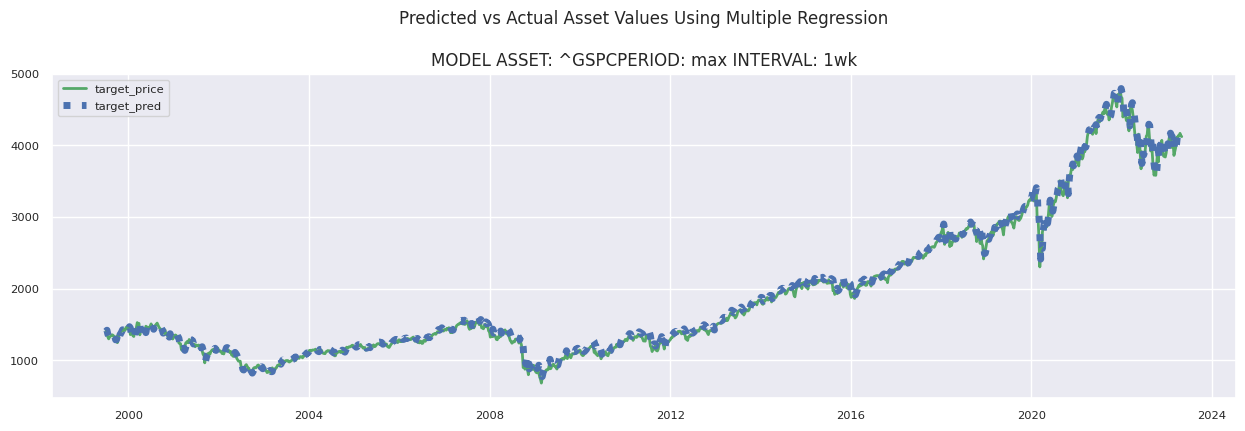


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  3861.59       4073.750   
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  3916.64       3919.954   
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  3970.99       3978.881   
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  4109.31       4020.189   
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  4105.02       4128.096   
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  4137.64       4136.890   
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  4133.52       4168.381   
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  4169.48       4174.054   
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  4136.25       4190.

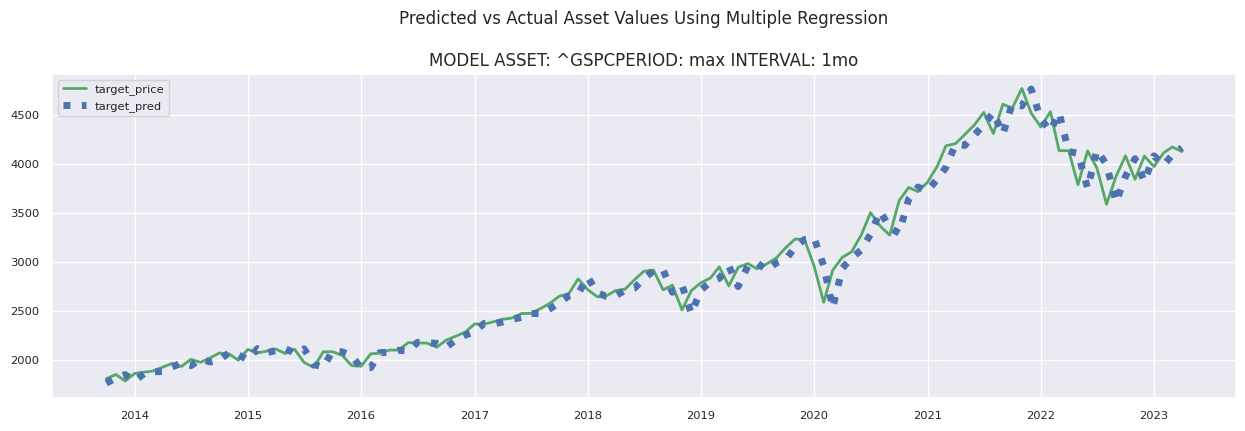


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_price  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  3955.00       4137.310   
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  3585.62       3989.300   
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  3871.98       3606.066   
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  4080.11       3868.906   
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  3839.50       4050.376   
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  4076.60       3818.013   
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  3970.15       4079.506   
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  4109.31       3985.187   
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  4169.48 

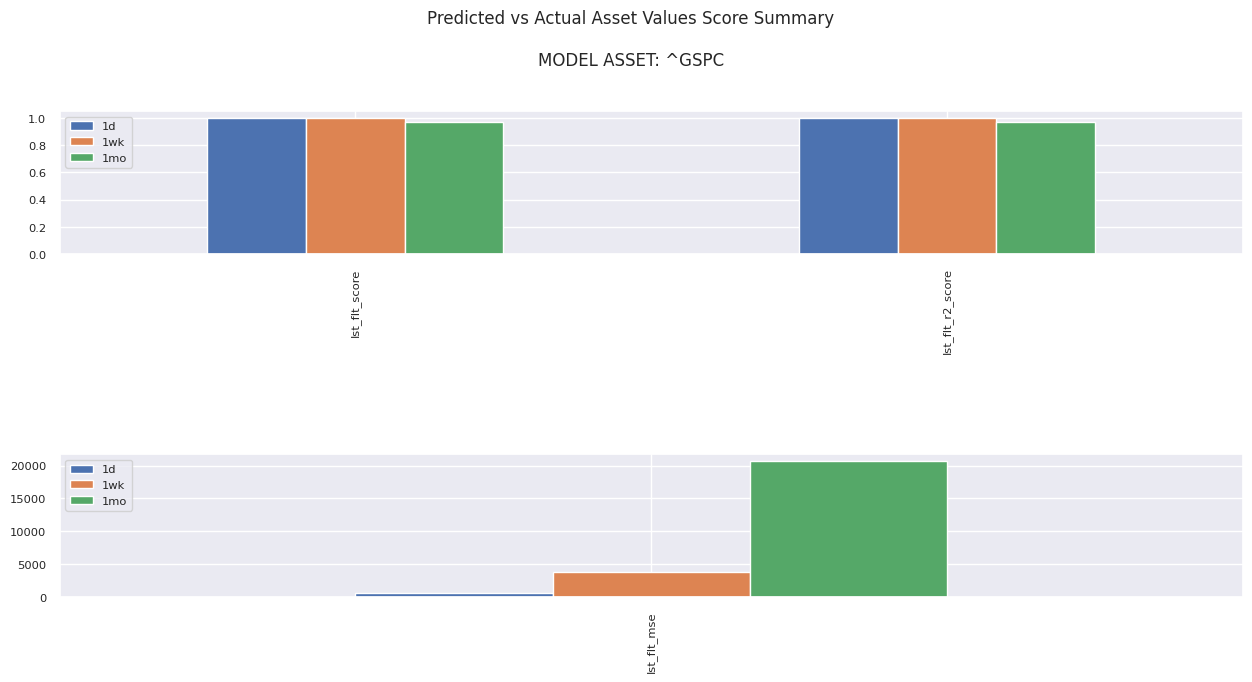


 

None

 
MODEL ASSET: ^DJI PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^DJI-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[-4.57382805e-02  1.43978820e-01  8.40514600e-02  8.17310999e-01
 -1.19107423e-08]
 

Model Intercept: 
 
5.046830289678837
 



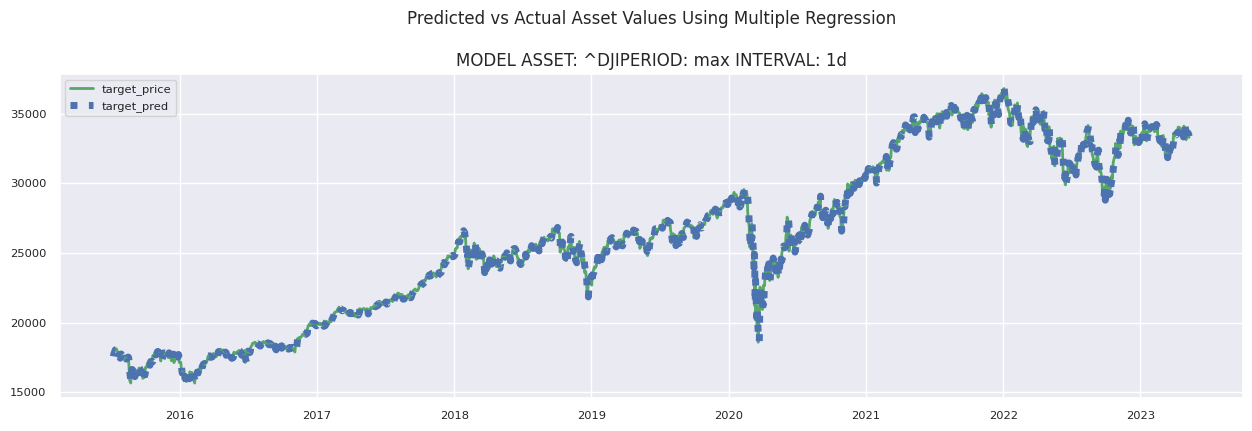


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume     target_price  target_pred
date                                                                                        
2023-04-28  33797.430  34104.559  33728.398  34098.160  354310000  34051.699     34069.047  
2023-05-01  34116.809  34257.828  34030.141  34051.699  244190000  33684.531     34065.207  
2023-05-02  34017.621  34017.750  33436.660  33684.531  274460000  33414.238     33684.844  
2023-05-03  33726.641  33811.840  33396.051  33414.238  286900000  33127.738     33444.031  
2023-05-04  33347.781  33354.859  32937.500  33127.738  305160000  33674.379     33122.645  
2023-05-05  33248.551  33748.430  33248.551  33674.379  316350000  33618.691     33656.636  
2023-05-08  33715.148  33747.488  33509.230  33618.691  225680000  33561.809     33612.635  
2023-05-09  33589.852  33656.398  33509.719  33561.809  232940000  33531.328     33558.715  
2023-05-10  33707.19

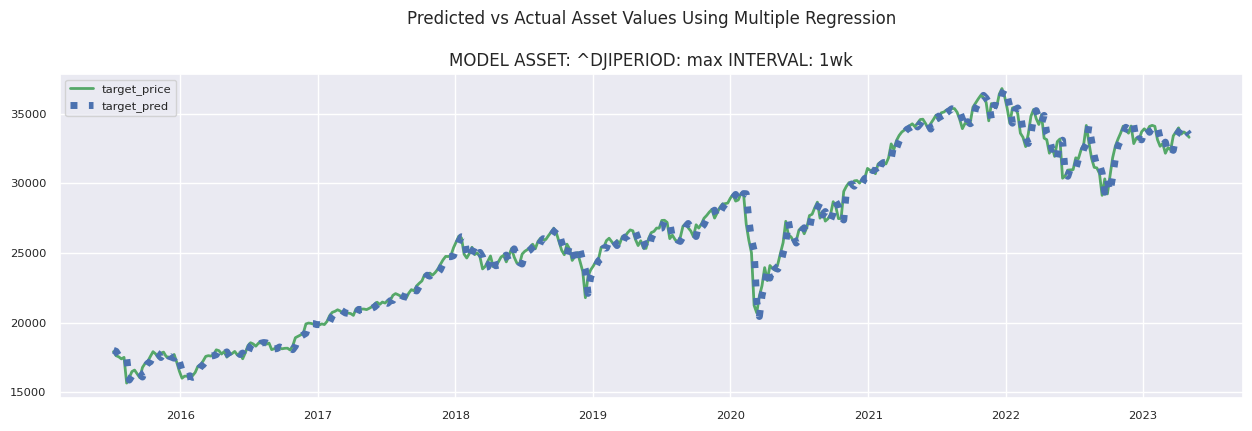


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume      target_price  target_pred
date                                                                                         
2023-03-01  32656.369  33572.219  32500.711  32856.461  1538900000  32155.400     32954.399  
2023-03-08  32872.078  32990.461  31624.869  32155.400  1777250000  32560.600     32185.969  
2023-03-15  31759.869  32593.680  31429.820  32560.600  2294350000  32394.250     32469.442  
2023-03-22  32570.189  32761.891  31805.180  32394.250  1518610000  33402.379     32363.146  
2023-03-29  32566.539  33634.719  32539.939  33402.379  1546480000  33684.789     33393.652  
2023-04-05  33394.602  33781.289  33325.371  33684.789  1019690000  33976.629     33659.992  
2023-04-12  33764.211  34082.941  33593.320  33976.629  1302350000  33530.828     33941.225  
2023-04-19  33889.828  33957.980  33525.391  33530.828  1400380000  33684.531     33557.154  
2023-04-26

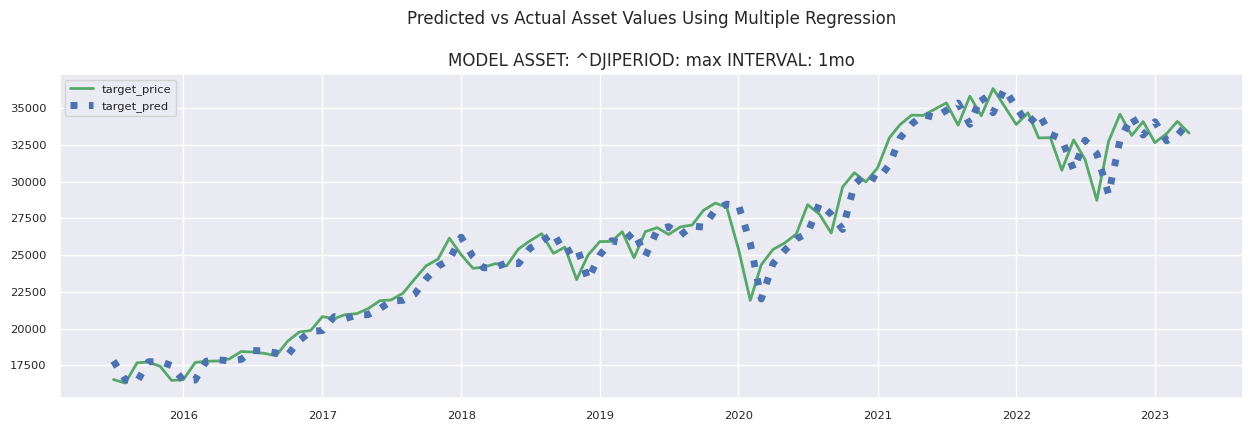


 

Feature, Target and Prediction Comparison: 
 
            open       high       low        close      volume      target_price  target_pred
date                                                                                         
2022-07-01  30737.770  32910.180  30143.930  32845.129  6354530000  31510.430     32816.179  
2022-08-01  32755.711  34281.359  31509.590  31510.430  6960090000  28725.510     31912.586  
2022-09-01  31454.580  32504.039  28715.850  28725.510  7785160000  32732.949     29133.114  
2022-10-01  28855.250  32889.809  28660.939  32732.949  7758140000  34589.770     32826.500  
2022-11-01  32862.789  34589.770  31727.051  34589.770  7214910000  33147.250     34453.168  
2022-12-01  34533.590  34712.281  32573.430  33147.250  6980640000  34086.039     33169.462  
2023-01-01  33148.898  34342.320  32812.328  34086.039  6774530000  32656.699     34075.290  
2023-02-01  34039.602  34334.699  32636.430  32656.699  6105230000  33274.148     32781.946  
2023-03-01

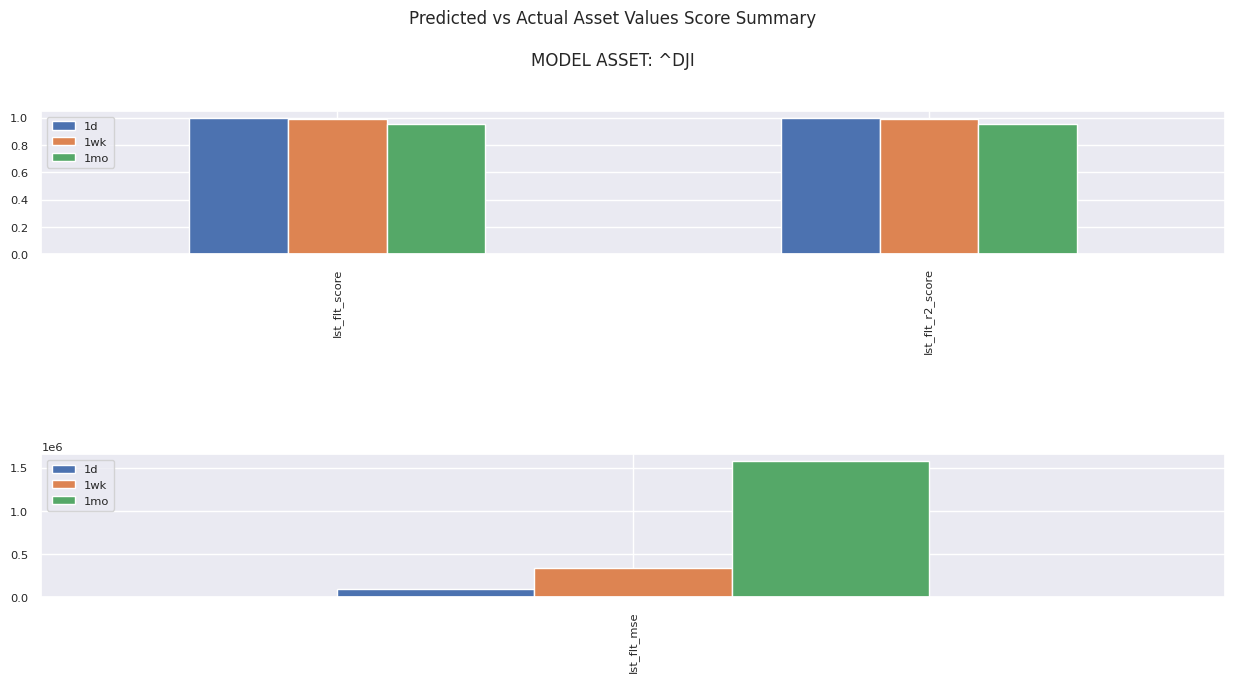


 

None

 
MODEL ASSET: ^GSPC PERIOD: max INTERVAL: 1d
FILE EXISTS: /content/drive/MyDrive/Colab Notebooks/input/^GSPC-price-data-max-1d.csv UPDATE: NO
 

Model Coefficents: 
 
[ 1.38421888e-03  1.09736775e-01 -9.22012809e-02  9.80540094e-01
 -2.08889100e-10]
 

Model Intercept: 
 
0.029760617776872778
 



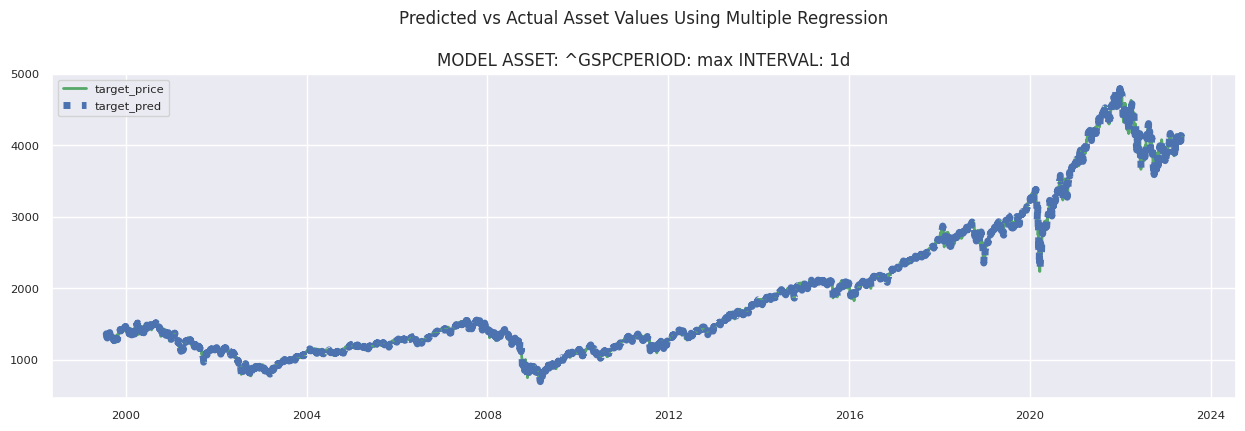


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume      target_price  target_pred
date                                                                                 
2023-04-28  4129.63  4170.06  4127.18  4169.48  4087800000  4167.87       4170.312   
2023-05-01  4166.79  4186.92  4164.12  4167.87  3321370000  4119.58       4167.389   
2023-05-02  4164.10  4164.10  4089.72  4119.58  4486130000  4090.75       4124.148   
2023-05-03  4122.25  4148.30  4088.86  4090.75  4246510000  4061.22       4094.216   
2023-05-04  4082.55  4082.61  4048.28  4061.22  4920090000  4136.25       4061.598   
2023-05-05  4084.73  4147.02  4084.73  4136.25  4186270000  4138.12       4139.032   
2023-05-08  4136.98  4142.30  4123.81  4138.12  3641640000  4119.17       4136.930   
2023-05-09  4124.25  4130.35  4116.65  4119.17  3810140000  4137.64       4117.645   
2023-05-10  4143.74  4154.28  4098.92  4137.64  4057160000  4130.62       4139.992   
2023

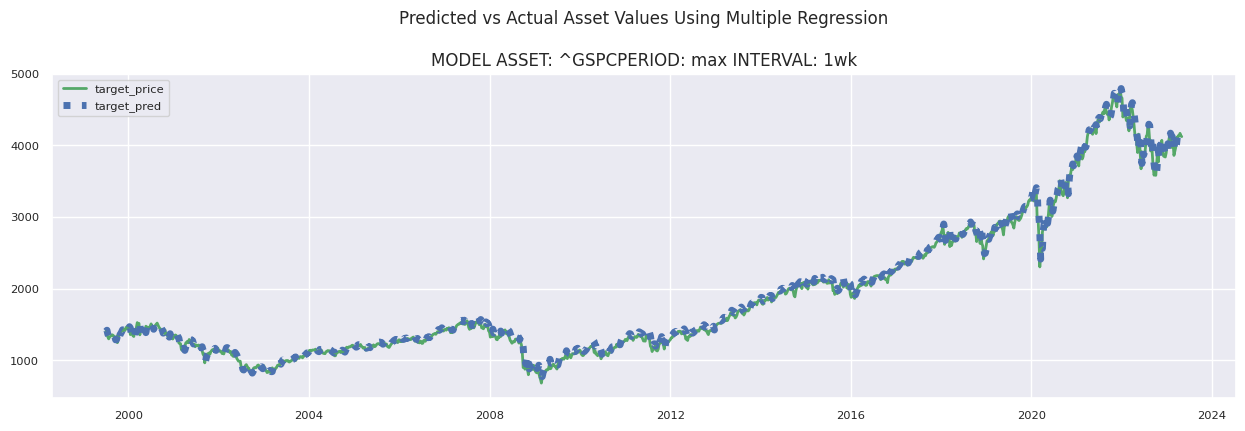


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume       target_price  target_pred
date                                                                                  
2023-02-27  3992.36  4048.29  3928.16  4045.64  21459460000  3861.59       4073.750   
2023-03-06  4055.15  4078.49  3846.32  3861.59  21422390000  3916.64       3919.954   
2023-03-13  3835.12  3964.46  3808.86  3916.64  33867970000  3970.99       3978.881   
2023-03-20  3917.47  4039.49  3909.16  3970.99  24375960000  4109.31       4020.189   
2023-03-27  3982.93  4110.75  3951.53  4109.31  20849370000  4105.02       4128.096   
2023-04-03  4102.20  4133.13  4069.84  4105.02  15917210000  4137.64       4136.890   
2023-04-10  4085.20  4163.19  4072.55  4137.64  17894880000  4133.52       4168.381   
2023-04-17  4137.17  4169.48  4113.86  4133.52  18104210000  4169.48       4174.054   
2023-04-24  4132.07  4170.06  4049.35  4169.48  18944960000  4136.25       4190.

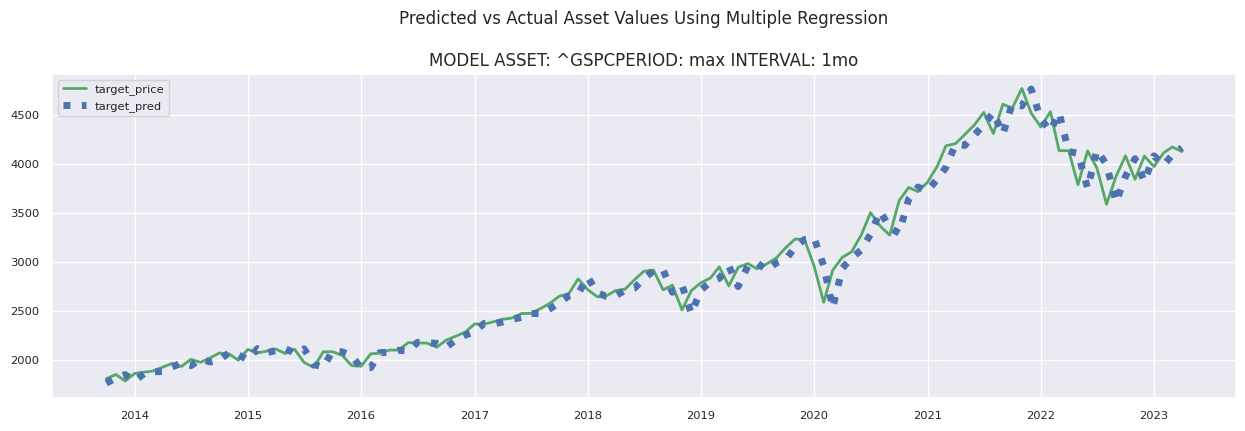


 

Feature, Target and Prediction Comparison: 
 
            open     high     low      close    volume        target_price  target_pred
date                                                                                   
2022-07-01  3781.00  4140.15  3721.56  4130.29   81688320000  3955.00       4137.310   
2022-08-01  4112.38  4325.28  3954.53  3955.00   92252350000  3585.62       3989.300   
2022-09-01  3936.73  4119.28  3584.13  3585.62   94241020000  3871.98       3606.066   
2022-10-01  3609.78  3905.42  3491.58  3871.98   95823760000  4080.11       3868.906   
2022-11-01  3901.79  4080.11  3698.15  4080.11   92671910000  3839.50       4050.376   
2022-12-01  4087.14  4100.96  3764.49  3839.50   85249330000  4076.60       3818.013   
2023-01-01  3853.29  4094.21  3794.33  4076.60   80763810000  3970.15       4079.506   
2023-02-01  4070.07  4195.44  3943.08  3970.15   80392280000  4109.31       3985.187   
2023-03-01  3963.34  4110.75  3808.86  4109.31  113094800000  4169.48 

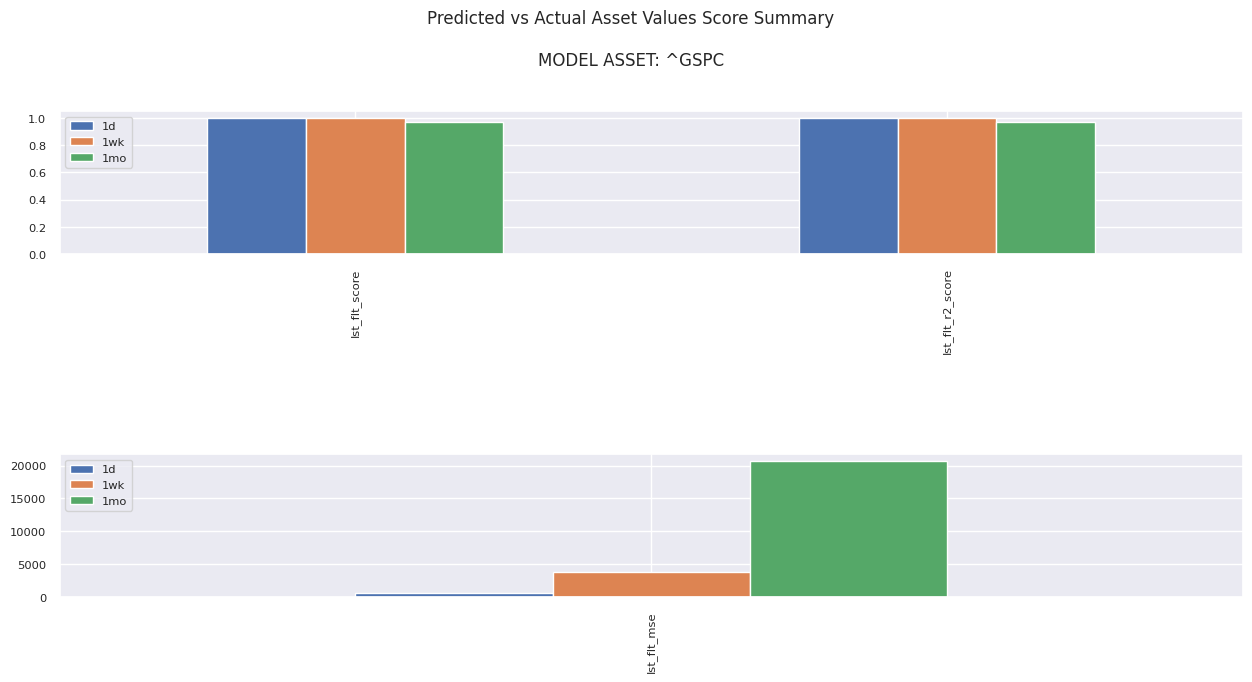


 

None


In [17]:
AssetData(str_co_ticker_1).run_mlr_model_list([str_co_ticker_1, str_co_ticker_2])